In [ ]:
import os
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
#from datasets import load_dataset, concatenate_datasets
import numpy as np
import io
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input

In [ ]:
#data_path = '/content/drive/MyDrive/data'

train_files = [
    f"C:/Users/T2420322/Desktop/Mugdho/Dataset/train-00000-of-00002.parquet",
    f"C:/Users/T2420322/Desktop/Mugdho/Dataset/train-00001-of-00002.parquet"
]
test_file = f"C:/Users/T2420322/Desktop/Mugdho/Dataset/test-00000-of-00001.parquet"


In [ ]:
dfs = [pd.read_parquet(f) for f in train_files]
df_train = pd.concat(dfs, ignore_index=True)

df_test = pd.read_parquet(test_file)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (8000, 3)
Test shape: (2000, 3)


In [ ]:
df_train.head(10)

,image,label,id_str
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,1,train_galaxy_0
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,1,train_galaxy_1
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,3,train_galaxy_2
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,1,train_galaxy_3
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,3,train_galaxy_4
5,<PIL.PngImagePlugin.PngImageFile image mode=RG...,3,train_galaxy_5
6,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0,train_galaxy_6
7,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0,train_galaxy_7
8,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0,train_galaxy_8
9,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0,train_galaxy_9


In [ ]:
y_true = df_train['label'].values
df_trainf = df_train.drop(columns=['label'])
df_trainf

,image,id_str
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,train_galaxy_0
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,train_galaxy_1
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,train_galaxy_2
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,train_galaxy_3
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,train_galaxy_4
...,...,...
7995,<PIL.PngImagePlugin.PngImageFile image mode=RG...,train_galaxy_7995
7996,<PIL.PngImagePlugin.PngImageFile image mode=RG...,train_galaxy_7996
7997,<PIL.PngImagePlugin.PngImageFile image mode=RG...,train_galaxy_7997
7998,<PIL.PngImagePlugin.PngImageFile image mode=RG...,train_galaxy_7998


In [ ]:
y_true_test = df_test['label'].values
df_testf = df_test.drop(columns=['label'])
df_testf.head(10)

,image,id_str
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_0
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_1
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_2
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_3
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_4
5,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_5
6,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_6
7,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_7
8,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_8
9,<PIL.PngImagePlugin.PngImageFile image mode=RG...,test_galaxy_9


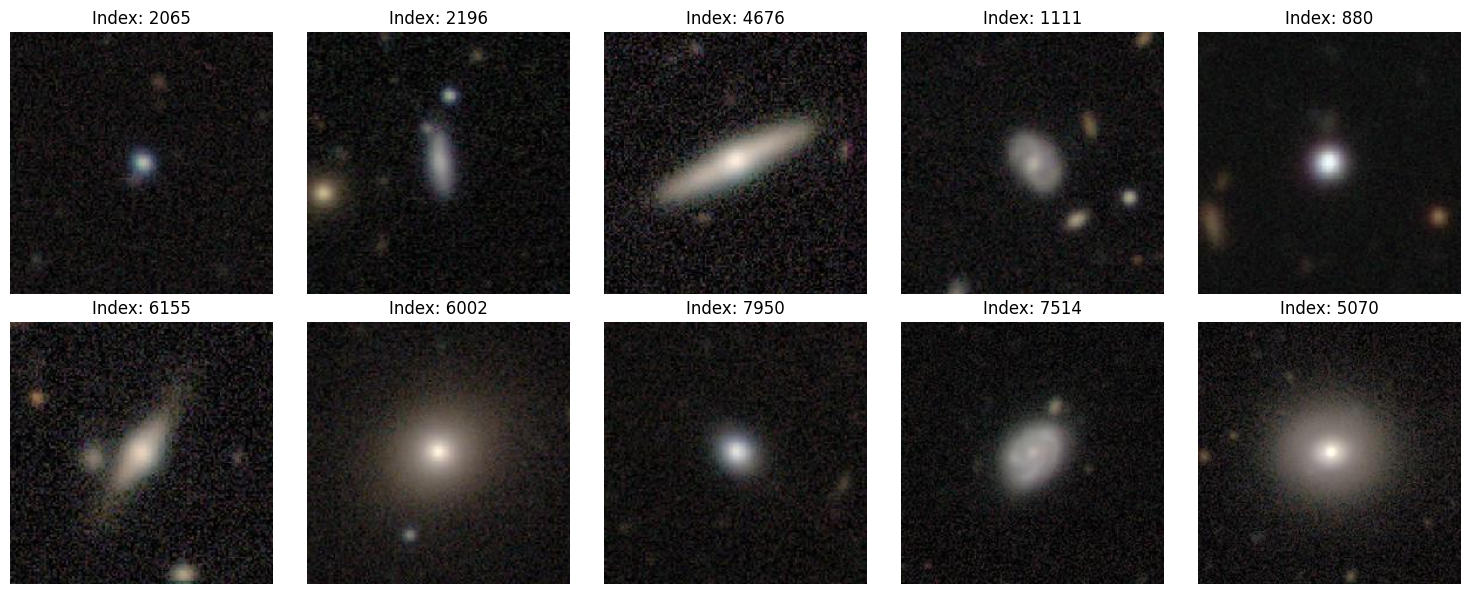

In [ ]:
import random
random_indices = random.sample(range(len(df_train)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, idx in zip(axes, random_indices):
    img = df_train.loc[idx, 'image']
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Index: {idx}")

plt.tight_layout()
plt.show()

In [ ]:
X = np.stack(df_trainf['image'].apply(np.array)) / 255.0  # shape: (N, 224, 224, 3)
print("Input shape:", X.shape)

Input shape: (8000, 224, 224, 3)


In [ ]:
X_preprocessed = preprocess_input(X.copy())  # follows ImageNet normalization

# Build ResNet50 model without classification head
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
gap_layer = tf.keras.layers.GlobalAveragePooling2D()(resnet_base.output)
feature_model = Model(inputs=resnet_base.input, outputs=gap_layer)

# Extract features
features = feature_model.predict(X_preprocessed, batch_size=32, verbose=1)  # shape: (N, 2048)
print("Extracted features shape:", features.shape)

250/250 [==============================] - 4s 15ms/step
Extracted features shape: (8000, 2048)


In [ ]:
from tensorflow.keras import layers, models

def build_decoder(latent_dim=2048):
    decoder_input = layers.Input(shape=(latent_dim,))

    # Step 1: Project into a small spatial feature map
    x = layers.Dense(7 * 7 * 256, activation='relu')(decoder_input)
    x = layers.Reshape((7, 7, 256))(x)

    # Step 2: Upsample back to 224x224x3
    x = layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu')(x)  # 14x14
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)  # 28x28
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)   # 56x56
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)   # 112x112
    x = layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu')(x)   # 224x224

    # Final reconstruction layer
    output = layers.Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')(x)

    # Build model
    decoder = models.Model(inputs=decoder_input, outputs=output, name="vgg_style_decoder")
    return decoder

decoder = build_decoder(latent_dim=2048)
decoder.summary()


Model: "vgg_style_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_3 (Dense)             (None, 12544)             25702656  
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 14, 14, 256)      590080    
 Transpose)                                                      
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 28, 28, 128)      295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 56, 56, 64) 

In [ ]:
# Connect encoder (ResNet + GAP) and decoder
latent_input = resnet_base.input                       # Input image
latent_output = gap_layer                              # 2048-d latent vector from ResNet

reconstructed_img = decoder(latent_output)             # Decoder reconstructs image
autoencoder = Model(inputs=latent_input, outputs=reconstructed_img)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# X_preprocessed: input to ResNet
# X: original images normalized to [0,1] for output comparison
autoencoder.fit(X_preprocessed, X, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
225/225 [==============================] - 25s 93ms/step - loss: 0.0161 - val_loss: 0.0108
Epoch 2/50
225/225 [==============================] - 19s 84ms/step - loss: 0.0042 - val_loss: 0.0152
Epoch 3/50
225/225 [==============================] - 19s 84ms/step - loss: 0.0036 - val_loss: 0.0141
Epoch 4/50
225/225 [==============================] - 19s 84ms/step - loss: 0.0033 - val_loss: 0.0139
Epoch 5/50
225/225 [==============================] - 19s 84ms/step - loss: 0.0030 - val_loss: 0.0145
Epoch 6/50
225/225 [==============================] - 19s 84ms/step - loss: 0.0029 - val_loss: 0.0173
Epoch 7/50
225/225 [==============================] - 19s 84ms/step - loss: 0.0028 - val_loss: 0.0158
Epoch 8/50
225/225 [==============================] - 19s 84ms/step - loss: 0.0026 - val_loss: 0.0160
Epoch 9/50
225/225 [==============================] - 19s 84ms/step - loss: 0.0026 - val_loss: 0.0156
Epoch 10/50
225/225 [==============================] - 19s 84ms/step - loss: 0.002

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Apply K-Means clustering (e.g., with 10 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features_pca)

# Evaluate the clustering performance using Silhouette Score
sil_score = silhouette_score(features_pca, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.1377


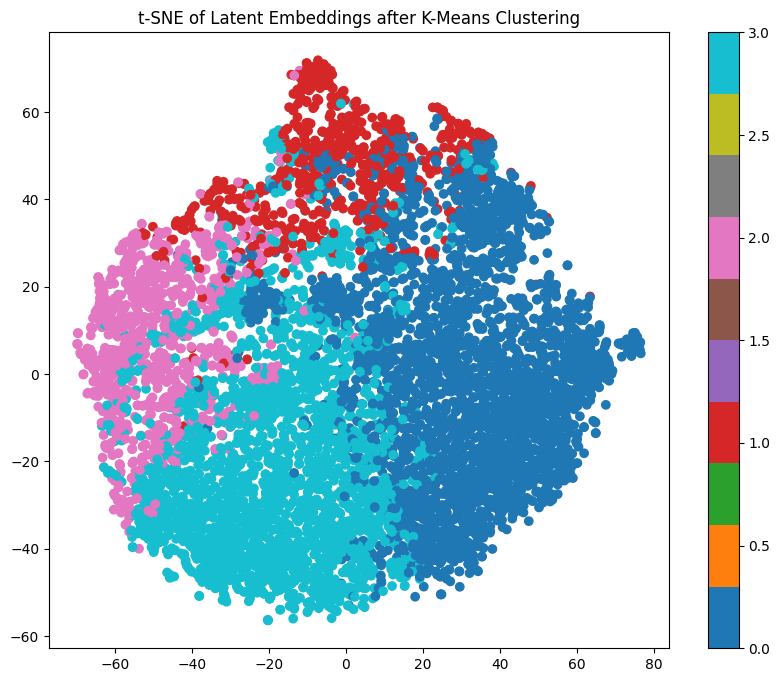

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_labels, cmap='tab10')
plt.title('t-SNE of Latent Embeddings after K-Means Clustering')
plt.colorbar()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(features_pca)

# Check the number of clusters (including noise)
unique_clusters = set(dbscan_labels)
print(f"DBSCAN found {len(unique_clusters)} clusters (including noise)")

DBSCAN found 2 clusters (including noise)


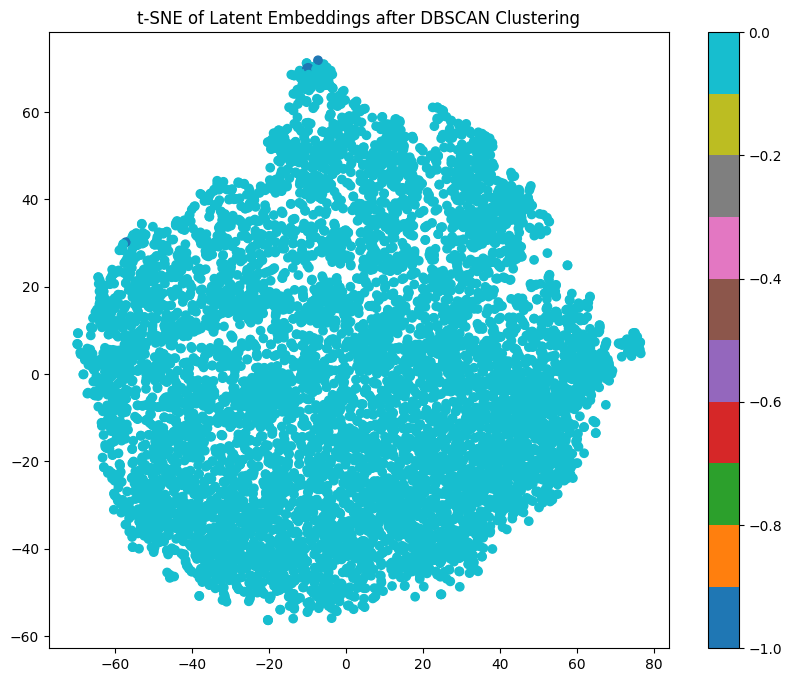

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='tab10')
plt.title('t-SNE of Latent Embeddings after DBSCAN Clustering')
plt.colorbar()
plt.show()


In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(features, cluster_labels)

# Calculate Calinski-Harabasz Index
ch_index = calinski_harabasz_score(features, cluster_labels)

# Display
print(f"Davies-Bouldin Index    : {db_index:.4f}")
print(f"Calinski-Harabasz Index : {ch_index:.2f}")

Davies-Bouldin Index    : 2.0858
Calinski-Harabasz Index : 694.47


In [ ]:
pip install minisom


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12102 sha256=f2d4e187772108f7509a2f8a47f6b5104c5bb1d028ddd0b551587484b2286a98
  Stored in directory: c:\users\t2420322\appdata\local\pip\cache\wheels\be\33\77\b6bb14008fa79a2dd2b79d565e941d5faa2d7f7526e528345b
Successfully built minisom


In [ ]:
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Step 0: Normalize ResNet feature vectors to [0, 1],
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)  # shape: (N, 2048)

# Step 1: Initialize and Train SOM,
som_x, som_y = 2, 2  # 2x2 grid = 4 clusters
som = MiniSom(som_x, som_y, input_len=features_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(features_scaled)
som.train(features_scaled, num_iteration=1000, verbose=True)

#Step 2: Assign Cluster Labels from SOM,
# Each sample gets mapped to a node (i,j),
som_labels = np.array([som.winner(x) for x in features_scaled])
# Convert (i,j) pairs to flat cluster indices (e.g., 0–3 for 2x2 SOM),
cluster_ids = np.array([i * som_y + j for i, j in som_labels])


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.5224746005765784



📊 Kohonen (SOM) Clustering Metrics:
Silhouette Score        : 0.1017
Davies-Bouldin Index    : 2.3500
Calinski-Harabasz Index : 661.31


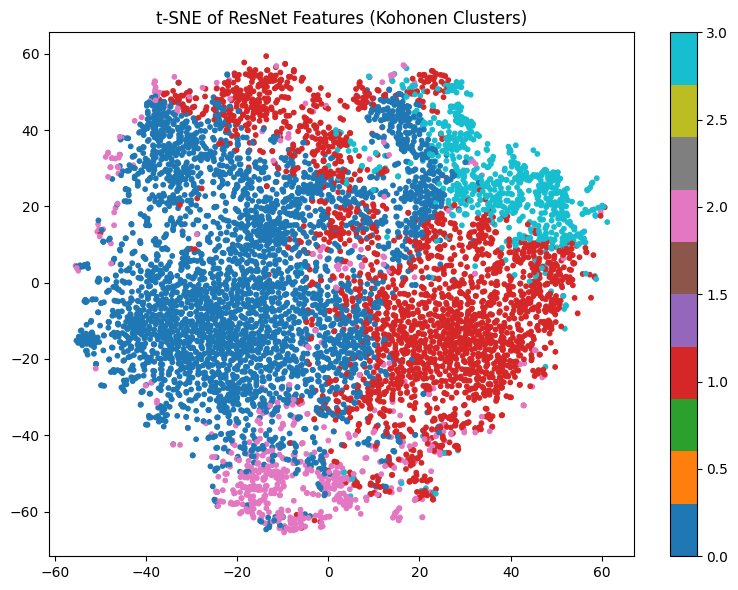

In [ ]:
sil = silhouette_score(features_scaled, cluster_ids)
db = davies_bouldin_score(features_scaled, cluster_ids)
ch = calinski_harabasz_score(features_scaled, cluster_ids)

print(f"\n📊 Kohonen (SOM) Clustering Metrics:")
print(f"Silhouette Score        : {sil:.4f}")
print(f"Davies-Bouldin Index    : {db:.4f}")
print(f"Calinski-Harabasz Index : {ch:.2f}")
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_ids, cmap='tab10', s=10)
plt.colorbar()
plt.title("t-SNE of ResNet Features (Kohonen Clusters)")
plt.tight_layout()
plt.show()

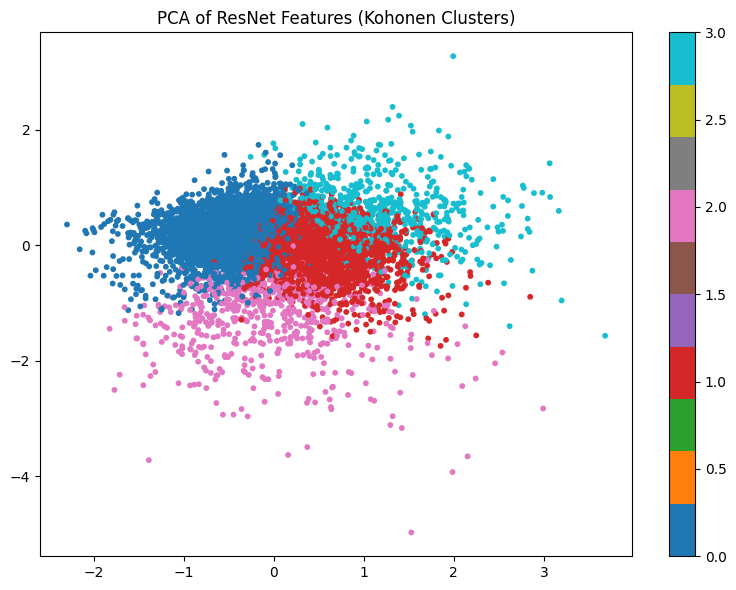

In [ ]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_ids, cmap='tab10', s=10)
plt.colorbar()
plt.title("PCA of ResNet Features (Kohonen Clusters)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_true, cluster_ids)
nmi = normalized_mutual_info_score(y_true, cluster_ids)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi:.4f}")

Adjusted Rand Index (ARI): 0.0274
Normalized Mutual Info (NMI): 0.0614
